# Model Implementation

In [1]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, regexp_extract
import shap

import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from pathlib import Path

import os

/opt/anaconda3/envs/bdcc-final-exam/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CACHE_DIR = Path('../_cache')
LOGS_DIR = Path('../_logs')
DATASET_DIR = Path('../datasets')
OUTPUT_DIR = Path('../outputs')

os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)
os.makedirs(DATASET_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
# === CONFIG ===
csv_file = DATASET_DIR / "no2_data" / "compiled_monthly_NO2_concentration.csv"
time_col = "month"
region_col = "region"

# === Load and Prepare Main DataFrame ===
df = pd.read_csv(csv_file, parse_dates=[time_col])
df.sort_values([region_col, time_col], inplace=True)
df["quarter_date"] = df[time_col].dt.to_period("Q").dt.start_time

print("[INFO] Main DataFrame:")
print(df[[region_col, time_col, "quarter_date"]].head())
print(df[[region_col, time_col]].dtypes)

[INFO] Main DataFrame:
  region      month quarter_date
0   Abra 2018-06-01   2018-04-01
1   Abra 2018-07-01   2018-07-01
2   Abra 2018-08-01   2018-07-01
3   Abra 2018-09-01   2018-07-01
4   Abra 2018-10-01   2018-10-01
region            object
month     datetime64[ns]
dtype: object


In [4]:
df

,region,month,NO2_umol_m2,quarter_date
0,Abra,2018-06-01,52.000815,2018-04-01
1,Abra,2018-07-01,56.317666,2018-07-01
2,Abra,2018-08-01,50.986105,2018-07-01
3,Abra,2018-09-01,50.598817,2018-07-01
4,Abra,2018-10-01,53.041432,2018-10-01
...,...,...,...,...
10159,Zamboanga del Sur,2025-01-01,33.553726,2025-01-01
10160,Zamboanga del Sur,2025-02-01,32.490319,2025-01-01
10161,Zamboanga del Sur,2025-03-01,32.573462,2025-01-01
10162,Zamboanga del Sur,2025-04-01,35.756933,2025-04-01


In [5]:
# === Start Spark Session ===
spark = SparkSession.builder.appName("FeatureLoader").getOrCreate()

# === Load External Feature Data ===
df1 = spark.read.option("recursiveFileLookup", "true").parquet(str(OUTPUT_DIR / "features"))
df1 = df1.withColumn(
    "quarter_date", regexp_extract(input_file_name(), r'features_quarter=(\d{4}-\d{2}-\d{2})', 1)
)

# Convert to pandas and clean
df1_pandas = df1.toPandas()
df1_pandas["quarter_date"] = pd.to_datetime(df1_pandas["quarter_date"])
df1_pandas.rename(columns={"gadm": region_col}, inplace=True)

import re

def normalize_region_name(s):
    if pd.isnull(s):
        return s
    return re.sub(r"[^\w\s]", "", s.lower().strip())

# Apply to both DataFrames
df[region_col] = df[region_col].apply(normalize_region_name)
df1_pandas[region_col] = df1_pandas[region_col].apply(normalize_region_name)

print("[INFO] External Features DataFrame (after cleaning):")
print(df1_pandas[[region_col, "quarter_date"]].drop_duplicates().head())

25/06/08 22:47:28 WARN Utils: Your hostname, PeteCastle.local resolves to a loopback address: 127.0.0.1; using 192.168.45.216 instead (on interface en0)
25/06/08 22:47:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/08 22:47:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/08 22:47:29 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/08 22:47:29 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/06/08 22:47:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


[INFO] External Features DataFrame (after cleaning):
            region quarter_date
0           cavite   2025-01-01
1           cavite   2025-04-01
2    city of davao   2025-01-01
3    city of davao   2025-04-01
4  negros oriental   2025-01-01


In [6]:
df1_pandas.head()

,region,\tUncategorized,animal_veterinary_services,art_galleries_exhibition_halls,automotive_repair_maintenance,beauty_personal_care_services,building_count,cemeteries_crematoria_memorials,commercial_office_buildings,community_social_service_centers,...,pu_storage_eq,coworking_startup_incubators,elderly_care_rehabilitation,pu_power,cultural_heritage_sites,public_squares_pedestrian_zones,bridges_tunnels_overpasses,rs_sari_sari,pu_monitoring,quarter_date
0,cavite,7.0,85.0,68.0,604.0,302.0,142698,48.0,1899.0,535.0,...,75.0,3.0,2.0,3.0,19.0,NaN,NaN,NaN,NaN,2025-01-01
1,cavite,7.0,88.0,80.0,618.0,320.0,142498,52.0,1918.0,565.0,...,82.0,3.0,2.0,3.0,19.0,NaN,NaN,NaN,NaN,2025-04-01
2,city of davao,1.0,49.0,45.0,426.0,230.0,61135,24.0,1113.0,283.0,...,24.0,6.0,2.0,4.0,NaN,NaN,NaN,1.0,NaN,2025-01-01
3,city of davao,1.0,50.0,47.0,434.0,234.0,61217,23.0,1107.0,286.0,...,24.0,6.0,3.0,4.0,NaN,NaN,NaN,1.0,NaN,2025-04-01
4,negros oriental,1.0,5.0,22.0,102.0,43.0,46835,4.0,156.0,89.0,...,5.0,NaN,1.0,5.0,1.0,NaN,NaN,NaN,NaN,2025-01-01


In [7]:
len(df1_pandas)

3276

In [8]:
print(df1_pandas.columns)

Index(['region', '\tUncategorized', 'animal_veterinary_services',
       'art_galleries_exhibition_halls', 'automotive_repair_maintenance',
       'beauty_personal_care_services', 'building_count',
       'cemeteries_crematoria_memorials', 'commercial_office_buildings',
       'community_social_service_centers', 'construction_building_services',
       'educational_institutions', 'emergency_services',
       'entertainment_nightlife_venues', 'event_convention_centers',
       'financial_services_institutions', 'food_beverage_outlets',
       'gambling_casino_facilities', 'government_administrative_buildings',
       'healthcare_facilities', 'hospitality_accommodation',
       'industrial_manufacturing_facilities', 'parking_vehicle_services',
       'parks_green_spaces', 'pu_fuel_gas', 'pu_water',
       'public_transportation_non_terminals', 'religious_structures',
       'residential_buildings', 'rs_big_retail', 'rs_other_store',
       'sports_recreation_complexes', 'telecommunicatio

In [9]:
# === Merge ===
merged = pd.merge(df, df1_pandas, on=[region_col, "quarter_date"], how="left")

print("[INFO] Merged DataFrame sample:")
print(merged[[region_col, "quarter_date"] + df1_pandas.columns.difference([region_col, "quarter_date"]).tolist()].head())

[INFO] Merged DataFrame sample:
  region quarter_date  \tUncategorized  agricultural_farming_facilities  \
0   abra   2018-04-01              NaN                              NaN   
1   abra   2018-07-01              NaN                            156.0   
2   abra   2018-07-01              NaN                            156.0   
3   abra   2018-07-01              NaN                            156.0   
4   abra   2018-10-01              NaN                            156.0   

   animal_veterinary_services  art_galleries_exhibition_halls  \
0                         NaN                             NaN   
1                         NaN                             NaN   
2                         NaN                             NaN   
3                         NaN                             NaN   
4                         NaN                             NaN   

   automotive_repair_maintenance  beaches_waterfronts_marinas  \
0                            NaN                          NaN

In [10]:
# === Merge Diagnostics ===
feature_cols = df1_pandas.columns.difference([region_col, "quarter_date"])
num_rows = len(df)
matched_rows = merged[feature_cols].notna().any(axis=1).sum()
missing_ext = merged[feature_cols].isna().all(axis=1).sum()

print(f"[INFO] Total rows in main data: {num_rows}")
print(f"[INFO] Rows with at least one external feature match: {matched_rows}")
print(f"[WARNING] Rows with all external features missing: {missing_ext}")

# === Identify Missing Region-Quarter Pairs (excluding 2018-04-01) ===
missing_rows = merged[merged[feature_cols].isna().all(axis=1)]
missing_pairs = (
    missing_rows[[region_col, "quarter_date"]]
    .drop_duplicates()
    .query("quarter_date != '2018-04-01'")
    .sort_values([region_col, "quarter_date"])
)

print("[DIAG] Sample of missing (region, quarter_date) pairs:")
print(missing_pairs.head(50))

unique_missing_regions = missing_pairs[region_col].unique()
unique_missing_dates = missing_pairs["quarter_date"].sort_values().unique()

print("\n[DIAG] Unique regions with missing external features (case-insensitive merge):")
print(unique_missing_regions)

print("\n[DIAG] Unique quarter_date values with missing external features:")
print(unique_missing_dates)


[INFO] Total rows in main data: 10332
[INFO] Rows with at least one external feature match: 9711
[WARNING] Rows with all external features missing: 621
[DIAG] Sample of missing (region, quarter_date) pairs:
                 region quarter_date
2689   city of cotabato   2018-07-01
2692   city of cotabato   2018-10-01
2695   city of cotabato   2019-01-01
2698   city of cotabato   2019-04-01
2701   city of cotabato   2019-07-01
2704   city of cotabato   2019-10-01
2707   city of cotabato   2020-01-01
2710   city of cotabato   2020-04-01
2713   city of cotabato   2020-07-01
2716   city of cotabato   2020-10-01
2719   city of cotabato   2021-01-01
2722   city of cotabato   2021-04-01
2725   city of cotabato   2021-07-01
2728   city of cotabato   2021-10-01
2731   city of cotabato   2022-01-01
2734   city of cotabato   2022-04-01
2737   city of cotabato   2022-07-01
2740   city of cotabato   2022-10-01
2743   city of cotabato   2023-01-01
2746   city of cotabato   2023-04-01
2749   city of c

/var/folders/94/qqxkptrd1bg66t_3104htv1m0000gn/T/ipykernel_16464/1467673323.py:16: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  .query("quarter_date != '2018-04-01'")


In [11]:
merged

,region,month,NO2_umol_m2,quarter_date,\tUncategorized,animal_veterinary_services,art_galleries_exhibition_halls,automotive_repair_maintenance,beauty_personal_care_services,building_count,...,maritime_dock_facilities,pu_storage_eq,coworking_startup_incubators,elderly_care_rehabilitation,pu_power,cultural_heritage_sites,public_squares_pedestrian_zones,bridges_tunnels_overpasses,rs_sari_sari,pu_monitoring
0,abra,2018-06-01,52.000815,2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abra,2018-07-01,56.317666,2018-07-01,NaN,NaN,NaN,5.0,1.0,38313.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,abra,2018-08-01,50.986105,2018-07-01,NaN,NaN,NaN,5.0,1.0,38313.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,abra,2018-09-01,50.598817,2018-07-01,NaN,NaN,NaN,5.0,1.0,38313.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,abra,2018-10-01,53.041432,2018-10-01,NaN,NaN,NaN,5.0,1.0,38348.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,zamboanga del sur,2025-01-01,33.553726,2025-01-01,NaN,NaN,1.0,10.0,8.0,73838.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10328,zamboanga del sur,2025-02-01,32.490319,2025-01-01,NaN,NaN,1.0,10.0,8.0,73838.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10329,zamboanga del sur,2025-03-01,32.573462,2025-01-01,NaN,NaN,1.0,10.0,8.0,73838.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10330,zamboanga del sur,2025-04-01,35.756933,2025-04-01,NaN,NaN,1.0,10.0,8.0,73840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
merged["month"].unique()

<DatetimeArray>
['2018-06-01 00:00:00', '2018-07-01 00:00:00', '2018-08-01 00:00:00',
 '2018-09-01 00:00:00', '2018-10-01 00:00:00', '2018-11-01 00:00:00',
 '2018-12-01 00:00:00', '2019-01-01 00:00:00', '2019-02-01 00:00:00',
 '2019-03-01 00:00:00', '2019-04-01 00:00:00', '2019-05-01 00:00:00',
 '2019-06-01 00:00:00', '2019-07-01 00:00:00', '2019-08-01 00:00:00',
 '2019-09-01 00:00:00', '2019-10-01 00:00:00', '2019-11-01 00:00:00',
 '2019-12-01 00:00:00', '2020-01-01 00:00:00', '2020-02-01 00:00:00',
 '2020-03-01 00:00:00', '2020-04-01 00:00:00', '2020-05-01 00:00:00',
 '2020-06-01 00:00:00', '2020-07-01 00:00:00', '2020-08-01 00:00:00',
 '2020-09-01 00:00:00', '2020-10-01 00:00:00', '2020-11-01 00:00:00',
 '2020-12-01 00:00:00', '2021-01-01 00:00:00', '2021-02-01 00:00:00',
 '2021-03-01 00:00:00', '2021-04-01 00:00:00', '2021-05-01 00:00:00',
 '2021-06-01 00:00:00', '2021-07-01 00:00:00', '2021-08-01 00:00:00',
 '2021-09-01 00:00:00', '2021-10-01 00:00:00', '2021-11-01 00:00:00',
 '20

In [13]:
print(merged.columns)

Index(['region', 'month', 'NO2_umol_m2', 'quarter_date', '\tUncategorized',
       'animal_veterinary_services', 'art_galleries_exhibition_halls',
       'automotive_repair_maintenance', 'beauty_personal_care_services',
       'building_count', 'cemeteries_crematoria_memorials',
       'commercial_office_buildings', 'community_social_service_centers',
       'construction_building_services', 'educational_institutions',
       'emergency_services', 'entertainment_nightlife_venues',
       'event_convention_centers', 'financial_services_institutions',
       'food_beverage_outlets', 'gambling_casino_facilities',
       'government_administrative_buildings', 'healthcare_facilities',
       'hospitality_accommodation', 'industrial_manufacturing_facilities',
       'parking_vehicle_services', 'parks_green_spaces', 'pu_fuel_gas',
       'pu_water', 'public_transportation_non_terminals',
       'religious_structures', 'residential_buildings', 'rs_big_retail',
       'rs_other_store', 'sports_

In [14]:
#merged = merged.drop("quarter_date", axis=1)

In [15]:
#merged = merged.drop("uncat__OTHER", axis=1)

In [16]:
#merged = merged.drop("\tUncategorized", axis=1)

In [17]:
print(merged.columns)

Index(['region', 'month', 'NO2_umol_m2', 'quarter_date', '\tUncategorized',
       'animal_veterinary_services', 'art_galleries_exhibition_halls',
       'automotive_repair_maintenance', 'beauty_personal_care_services',
       'building_count', 'cemeteries_crematoria_memorials',
       'commercial_office_buildings', 'community_social_service_centers',
       'construction_building_services', 'educational_institutions',
       'emergency_services', 'entertainment_nightlife_venues',
       'event_convention_centers', 'financial_services_institutions',
       'food_beverage_outlets', 'gambling_casino_facilities',
       'government_administrative_buildings', 'healthcare_facilities',
       'hospitality_accommodation', 'industrial_manufacturing_facilities',
       'parking_vehicle_services', 'parks_green_spaces', 'pu_fuel_gas',
       'pu_water', 'public_transportation_non_terminals',
       'religious_structures', 'residential_buildings', 'rs_big_retail',
       'rs_other_store', 'sports_

In [18]:
# Step 1: Identify non-feature columns to exclude
non_feature_cols = {region_col, "month", "_merge", "quarter_date"}  # quarter_date already dropped, but included for clarity

# Step 2: Detect actual feature columns present
feature_cols = [col for col in merged.columns if col not in non_feature_cols]

# Step 3: Drop rows where *all* feature columns are NaN
merged_cleaned = merged[~merged[feature_cols].isna().all(axis=1)].copy()

In [19]:
merged_cleaned

,region,month,NO2_umol_m2,quarter_date,\tUncategorized,animal_veterinary_services,art_galleries_exhibition_halls,automotive_repair_maintenance,beauty_personal_care_services,building_count,...,maritime_dock_facilities,pu_storage_eq,coworking_startup_incubators,elderly_care_rehabilitation,pu_power,cultural_heritage_sites,public_squares_pedestrian_zones,bridges_tunnels_overpasses,rs_sari_sari,pu_monitoring
0,abra,2018-06-01,52.000815,2018-04-01,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,abra,2018-07-01,56.317666,2018-07-01,NaN,NaN,NaN,5.0,1.0,38313.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,abra,2018-08-01,50.986105,2018-07-01,NaN,NaN,NaN,5.0,1.0,38313.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,abra,2018-09-01,50.598817,2018-07-01,NaN,NaN,NaN,5.0,1.0,38313.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,abra,2018-10-01,53.041432,2018-10-01,NaN,NaN,NaN,5.0,1.0,38348.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,zamboanga del sur,2025-01-01,33.553726,2025-01-01,NaN,NaN,1.0,10.0,8.0,73838.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10328,zamboanga del sur,2025-02-01,32.490319,2025-01-01,NaN,NaN,1.0,10.0,8.0,73838.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10329,zamboanga del sur,2025-03-01,32.573462,2025-01-01,NaN,NaN,1.0,10.0,8.0,73838.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10330,zamboanga del sur,2025-04-01,35.756933,2025-04-01,NaN,NaN,1.0,10.0,8.0,73840.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
regions_to_drop = [
    "city of cotabato",
    "compostela valley",
    "maguindanao",
    "metropolitan manila",
    "north cotabato",
    "ormoc city"
]

# Drop the regions
merged_cleaned = merged_cleaned[~merged_cleaned[region_col].isin(regions_to_drop)].copy()

In [21]:
merged_cleaned[merged_cleaned[region_col] == "city of cotabato"]

,region,month,NO2_umol_m2,quarter_date,\tUncategorized,animal_veterinary_services,art_galleries_exhibition_halls,automotive_repair_maintenance,beauty_personal_care_services,building_count,...,maritime_dock_facilities,pu_storage_eq,coworking_startup_incubators,elderly_care_rehabilitation,pu_power,cultural_heritage_sites,public_squares_pedestrian_zones,bridges_tunnels_overpasses,rs_sari_sari,pu_monitoring


In [22]:
len(merged_cleaned)

9828

In [23]:
merged_cleaned = merged_cleaned.fillna(0)

In [24]:
merged_cleaned

,region,month,NO2_umol_m2,quarter_date,\tUncategorized,animal_veterinary_services,art_galleries_exhibition_halls,automotive_repair_maintenance,beauty_personal_care_services,building_count,...,maritime_dock_facilities,pu_storage_eq,coworking_startup_incubators,elderly_care_rehabilitation,pu_power,cultural_heritage_sites,public_squares_pedestrian_zones,bridges_tunnels_overpasses,rs_sari_sari,pu_monitoring
0,abra,2018-06-01,52.000815,2018-04-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,abra,2018-07-01,56.317666,2018-07-01,0.0,0.0,0.0,5.0,1.0,38313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,abra,2018-08-01,50.986105,2018-07-01,0.0,0.0,0.0,5.0,1.0,38313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,abra,2018-09-01,50.598817,2018-07-01,0.0,0.0,0.0,5.0,1.0,38313.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,abra,2018-10-01,53.041432,2018-10-01,0.0,0.0,0.0,5.0,1.0,38348.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10327,zamboanga del sur,2025-01-01,33.553726,2025-01-01,0.0,0.0,1.0,10.0,8.0,73838.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10328,zamboanga del sur,2025-02-01,32.490319,2025-01-01,0.0,0.0,1.0,10.0,8.0,73838.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10329,zamboanga del sur,2025-03-01,32.573462,2025-01-01,0.0,0.0,1.0,10.0,8.0,73838.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10330,zamboanga del sur,2025-04-01,35.756933,2025-04-01,0.0,0.0,1.0,10.0,8.0,73840.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
merged_cleaned.columns.unique()

Index(['region', 'month', 'NO2_umol_m2', 'quarter_date', '\tUncategorized',
       'animal_veterinary_services', 'art_galleries_exhibition_halls',
       'automotive_repair_maintenance', 'beauty_personal_care_services',
       'building_count', 'cemeteries_crematoria_memorials',
       'commercial_office_buildings', 'community_social_service_centers',
       'construction_building_services', 'educational_institutions',
       'emergency_services', 'entertainment_nightlife_venues',
       'event_convention_centers', 'financial_services_institutions',
       'food_beverage_outlets', 'gambling_casino_facilities',
       'government_administrative_buildings', 'healthcare_facilities',
       'hospitality_accommodation', 'industrial_manufacturing_facilities',
       'parking_vehicle_services', 'parks_green_spaces', 'pu_fuel_gas',
       'pu_water', 'public_transportation_non_terminals',
       'religious_structures', 'residential_buildings', 'rs_big_retail',
       'rs_other_store', 'sports_

In [26]:
merged_cleaned.columns.nunique()

60

In [27]:
merged_cleaned[merged_cleaned["region"] == "city of makati"].head(10)

,region,month,NO2_umol_m2,quarter_date,\tUncategorized,animal_veterinary_services,art_galleries_exhibition_halls,automotive_repair_maintenance,beauty_personal_care_services,building_count,...,maritime_dock_facilities,pu_storage_eq,coworking_startup_incubators,elderly_care_rehabilitation,pu_power,cultural_heritage_sites,public_squares_pedestrian_zones,bridges_tunnels_overpasses,rs_sari_sari,pu_monitoring
3444,city of makati,2018-06-01,82.561028,2018-04-01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3445,city of makati,2018-07-01,90.392785,2018-07-01,0.0,5.0,27.0,76.0,50.0,21365.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3446,city of makati,2018-08-01,86.294584,2018-07-01,0.0,5.0,27.0,76.0,50.0,21365.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3447,city of makati,2018-09-01,113.881469,2018-07-01,0.0,5.0,27.0,76.0,50.0,21365.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3448,city of makati,2018-10-01,136.225026,2018-10-01,0.0,5.0,27.0,77.0,53.0,21337.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3449,city of makati,2018-11-01,104.282953,2018-10-01,0.0,5.0,27.0,77.0,53.0,21337.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3450,city of makati,2018-12-01,89.114431,2018-10-01,0.0,5.0,27.0,77.0,53.0,21337.0,...,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3451,city of makati,2019-01-01,81.585416,2019-01-01,0.0,5.0,28.0,79.0,55.0,21331.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3452,city of makati,2019-02-01,96.129276,2019-01-01,0.0,5.0,28.0,79.0,55.0,21331.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3453,city of makati,2019-03-01,115.557933,2019-01-01,0.0,5.0,28.0,79.0,55.0,21331.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
merged_cleaned["region"].unique()

array(['abra', 'agusan del norte', 'agusan del sur', 'aklan', 'albay',
       'antique', 'apayao', 'aurora', 'basilan', 'bataan', 'batanes',
       'batangas', 'benguet', 'biliran', 'bohol', 'bukidnon', 'bulacan',
       'cagayan', 'camarines norte', 'camarines sur', 'camiguin', 'capiz',
       'catanduanes', 'cavite', 'cebu', 'city of angeles',
       'city of bacolod', 'city of baguio', 'city of butuan',
       'city of cagayan de oro', 'city of caloocan', 'city of cebu',
       'city of davao', 'city of general santos', 'city of iligan',
       'city of iloilo', 'city of isabela', 'city of lapulapu',
       'city of las piñas', 'city of lucena', 'city of makati',
       'city of malabon', 'city of mandaluyong', 'city of mandaue',
       'city of manila', 'city of marikina', 'city of muntinlupa',
       'city of navotas', 'city of olongapo', 'city of parañaque',
       'city of pasig', 'city of puerto princesa', 'city of san juan',
       'city of tacloban', 'city of taguig', 'city o

In [29]:
merged_cleaned["region"].unique()

array(['abra', 'agusan del norte', 'agusan del sur', 'aklan', 'albay',
       'antique', 'apayao', 'aurora', 'basilan', 'bataan', 'batanes',
       'batangas', 'benguet', 'biliran', 'bohol', 'bukidnon', 'bulacan',
       'cagayan', 'camarines norte', 'camarines sur', 'camiguin', 'capiz',
       'catanduanes', 'cavite', 'cebu', 'city of angeles',
       'city of bacolod', 'city of baguio', 'city of butuan',
       'city of cagayan de oro', 'city of caloocan', 'city of cebu',
       'city of davao', 'city of general santos', 'city of iligan',
       'city of iloilo', 'city of isabela', 'city of lapulapu',
       'city of las piñas', 'city of lucena', 'city of makati',
       'city of malabon', 'city of mandaluyong', 'city of mandaue',
       'city of manila', 'city of marikina', 'city of muntinlupa',
       'city of navotas', 'city of olongapo', 'city of parañaque',
       'city of pasig', 'city of puerto princesa', 'city of san juan',
       'city of tacloban', 'city of taguig', 'city o

## FINAL MODEL IMPLEMENTATION

### 1 LOAD & PREPARE DATA

In [30]:
df = merged_cleaned.copy()
df['month'] = pd.to_datetime(df['month'])
df.sort_values(['region', 'month'], inplace=True)

# Persistence feature for naive baseline
df['NO2_prev_month'] = df.groupby('region')['NO2_umol_m2'].shift(1)
# Temporal features for XGBoost
df['month_num'] = df['month'].dt.month
#df['year'] = df['month'].dt.year
# Add HUC feature
huc_list = [
    'city of angeles', 'city of bacolod', 'city of baguio', 'city of butuan', 'city of cagayan de oro',
    'city of caloocan', 'city of cebu', 'city of davao', 'city of general santos', 'city of iligan',
    'city of iloilo', 'city of isabela', 'city of lapulapu', 'city of las piñas', 'city of lucena',
    'city of makati', 'city of malabon', 'city of mandaluyong', 'city of mandaue', 'city of manila',
    'city of marikina', 'city of muntinlupa', 'city of navotas', 'city of olongapo', 'city of parañaque',
    'city of pasig', 'city of puerto princesa', 'city of san juan', 'city of tacloban', 'city of taguig',
    'city of valenzuela', 'city of zamboanga', 'pasay city', 'quezon city', 'pateros'
]
df['huc'] = df['region'].str.lower().isin(huc_list).astype(int)

# Drop rows without previous-month value
df_full = df.dropna(subset=['NO2_prev_month']).reset_index(drop=True)

### 2 SPLIT & NAIVE EVALUATION

In [31]:
def time_based_split(df_, date_col='month', frac_train=0.8):
    uniq = np.sort(df_[date_col].unique())
    n = int(len(uniq) * frac_train)
    return df_[df_[date_col].isin(uniq[:n])], df_[df_[date_col].isin(uniq[n:])]


def evaluate_naive(df_val, target='NO2_umol_m2'):
    v = df_val.dropna(subset=['NO2_prev_month'])
    y_true, y_pred = v[target].values, v['NO2_prev_month'].values
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': mean_squared_error(y_true, y_pred)**0.5,
        'SMAPE': np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2 + 1e-3))
    }

# ------------------------------------------------------------
# 3) TRAIN & EVALUATE XGBOOST + SHAP + PDP + TOP10 FEATURES
# ------------------------------------------------------------
EXCLUDE = ['region', 'month', 'NO2_umol_m2', 'NO2_prev_month']

def train_and_evaluate_xgb(df_tr, df_vl, target='NO2_umol_m2', n_trials=30):
    import optuna
    import warnings

    # — Silence Optuna logs —
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    X_tr = df_tr.drop(columns=EXCLUDE, errors='ignore').select_dtypes(include='number')
    y_tr = df_tr[target].values
    X_vl = df_vl.drop(columns=EXCLUDE, errors='ignore').select_dtypes(include='number')
    y_vl = df_vl[target].values

    # Optuna hyperparameter tuning (minimize SMAPE), no progress bar
    def objective(trial):
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'n_estimators': trial.suggest_int('n_estimators', 50, 300),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'verbosity': 0,            # silence XGBoost
            'random_state': 42
        }
        model = xgb.XGBRegressor(**params).fit(X_tr, y_tr, verbose=False)
        preds = model.predict(X_vl)
        return np.mean(np.abs(y_vl - preds) / ((np.abs(y_vl) + np.abs(preds)) / 2 + 1e-3))

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # retrain with best params, still silent
    best_params = study.best_params
    best_params.update({'verbosity': 0, 'random_state': 42})
    model = xgb.XGBRegressor(**best_params).fit(X_tr, y_tr, verbose=False)

    preds = model.predict(X_vl)
    metrics = {
        'MAE': mean_absolute_error(y_vl, preds),
        'RMSE': mean_squared_error(y_vl, preds) ** 0.5,
        'SMAPE': np.mean(np.abs(y_vl - preds) / ((np.abs(y_vl) + np.abs(preds)) / 2 + 1e-3))
    }

    # SHAP analysis and Top-10 features
    explainer = shap.Explainer(model, X_tr)
    shap_vals = explainer(X_vl)
    feats = X_tr.columns.tolist()
    importances = np.abs(shap_vals.values).mean(axis=0)
    top10 = sorted(zip(feats, importances), key=lambda x: x[1], reverse=True)[:10]

    # 1) Summary bar plot
    shap.summary_plot(shap_vals, X_vl, plot_type='bar', feature_names=feats, show=True)
    # 2) Beeswarm plot
    shap.summary_plot(shap_vals, X_vl, feature_names=feats, show=True)

    # 3) Dependence plots for top 5 features
    for feat, _ in top10[:5]:
        shap.dependence_plot(
            feat,
            shap_vals.values,
            X_vl,
            feature_names=feats,
            show=True
        )

    # PDP plots for each top feature
    med = X_tr.median()
    for feat, _ in top10:
        grid = np.linspace(X_tr[feat].quantile(0.01), X_tr[feat].quantile(0.99), 50)
        # Build grid with same columns/order as training
        df_grid = pd.DataFrame(
            np.repeat(med.values[None, :], len(grid), axis=0),
            columns=feats
        )
        df_grid[feat] = grid
        y_grid = model.predict(df_grid)
        plt.figure(figsize=(6, 4))
        plt.plot(grid, y_grid, marker='o')
        plt.title(f'PDP: {feat}')
        plt.xlabel(feat)
        plt.ylabel('Predicted NO₂')
        plt.tight_layout()
        plt.show()

    return model, metrics, top10

### 3 EXECUTE FOR PRE/DURING/POST PERIODS

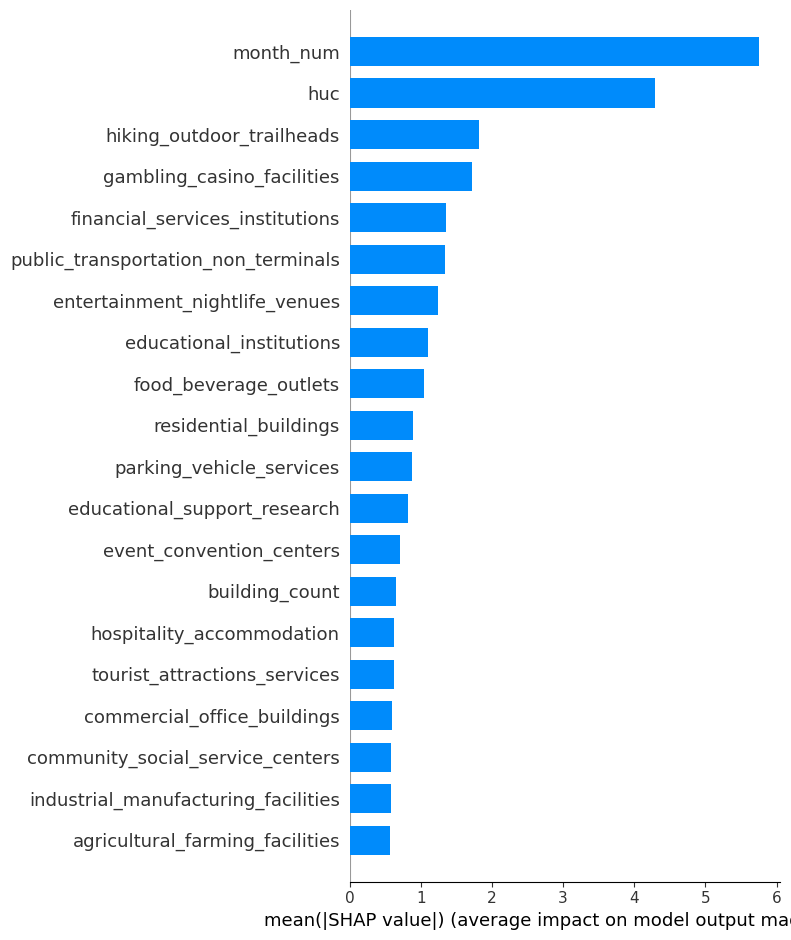

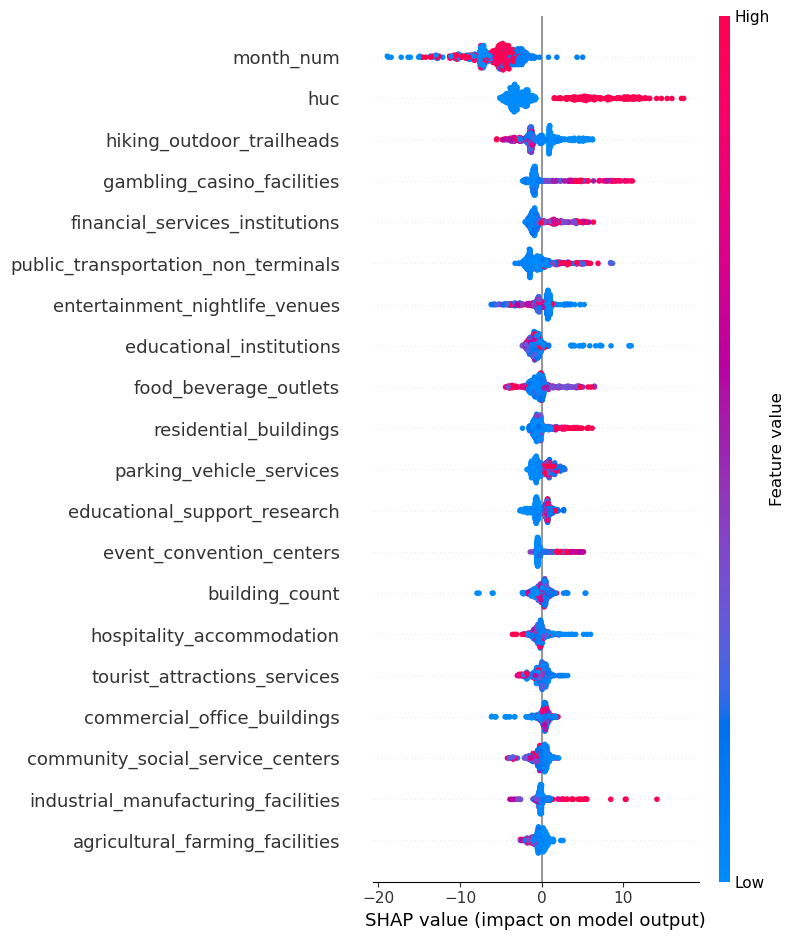

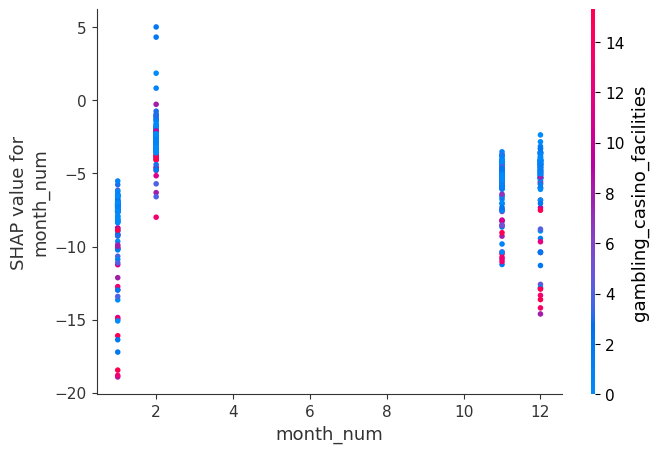

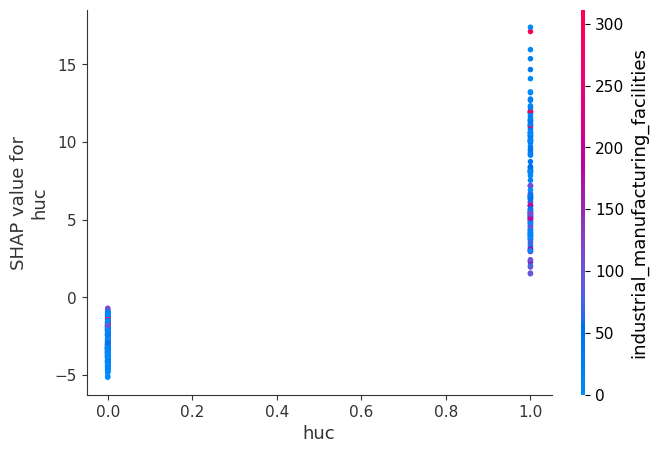

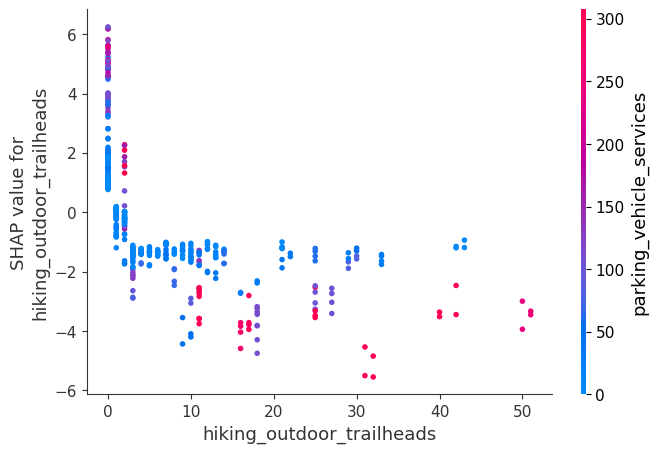

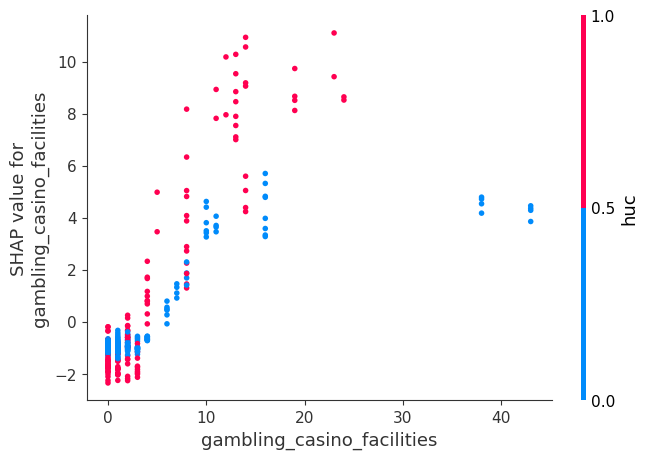

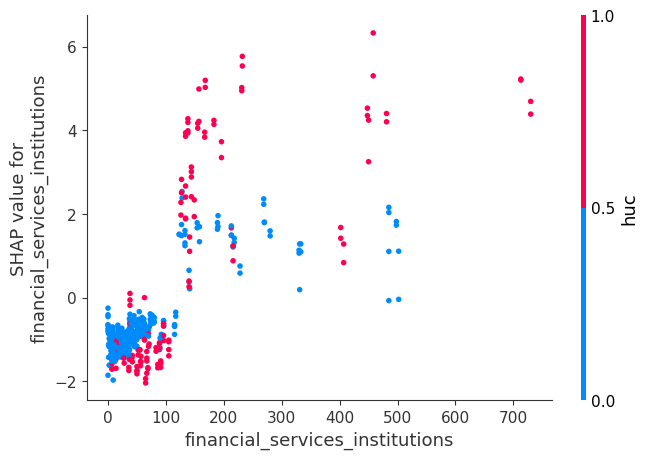

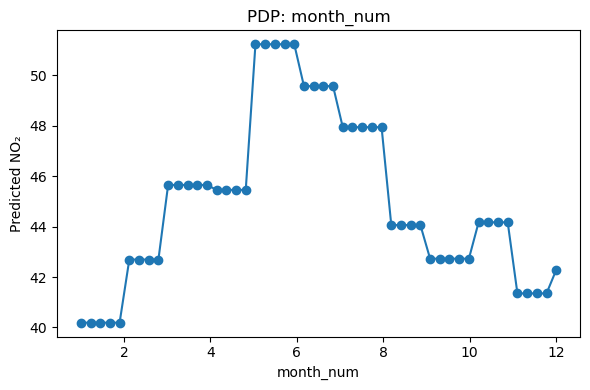

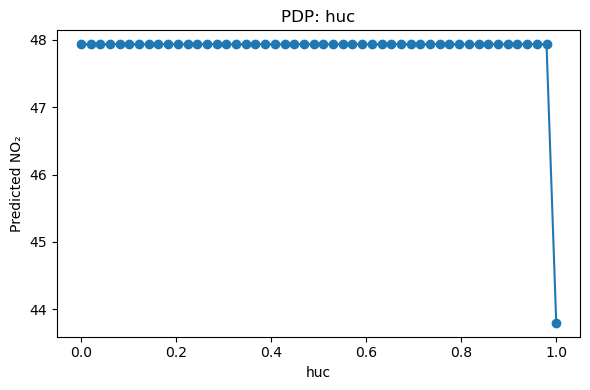

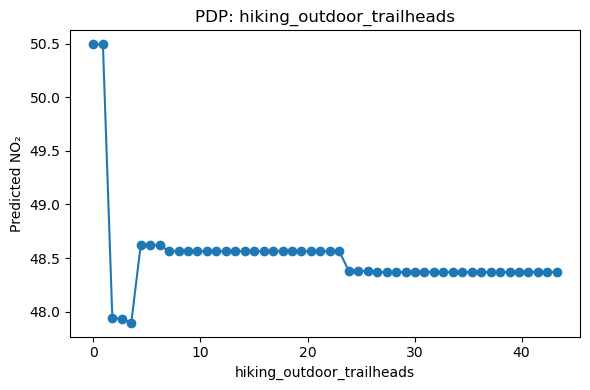

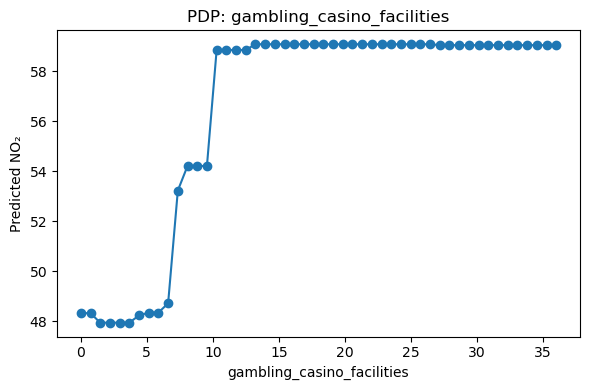

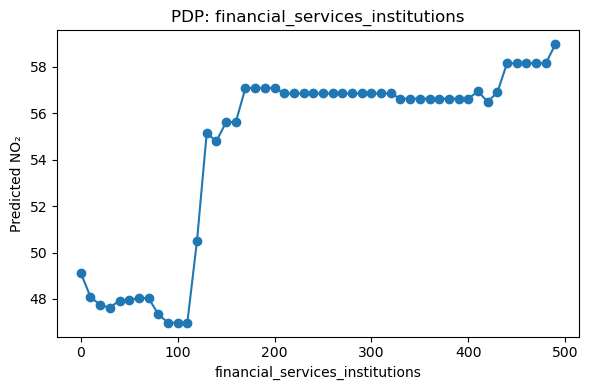

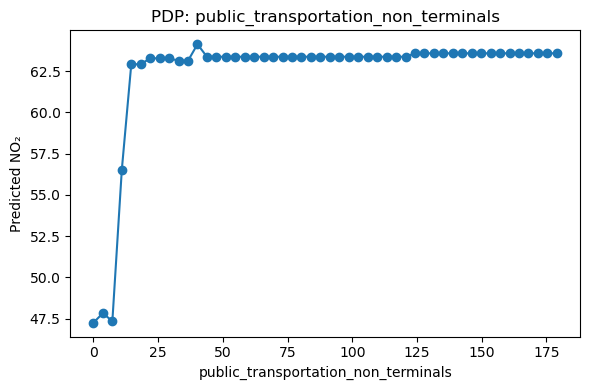

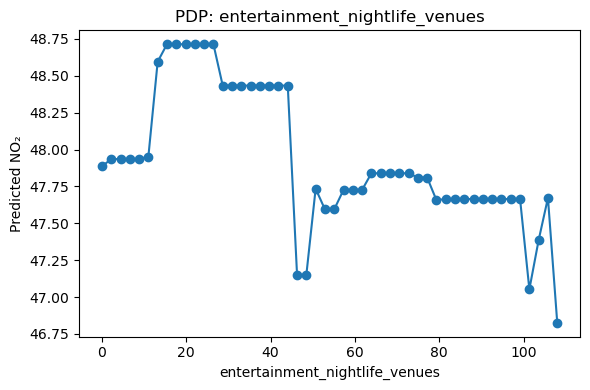

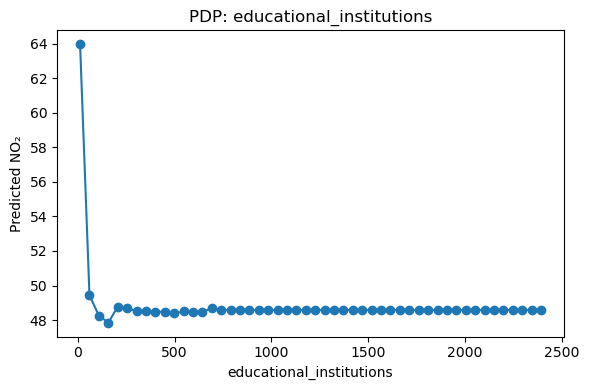

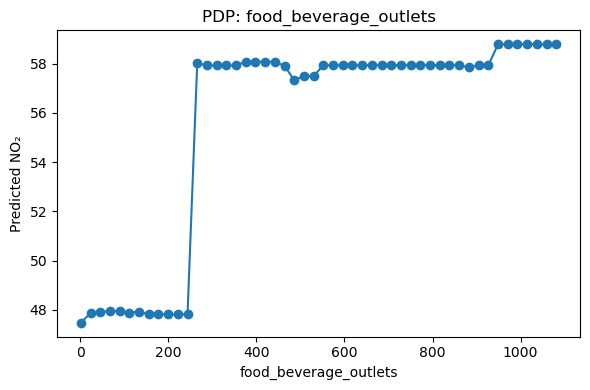

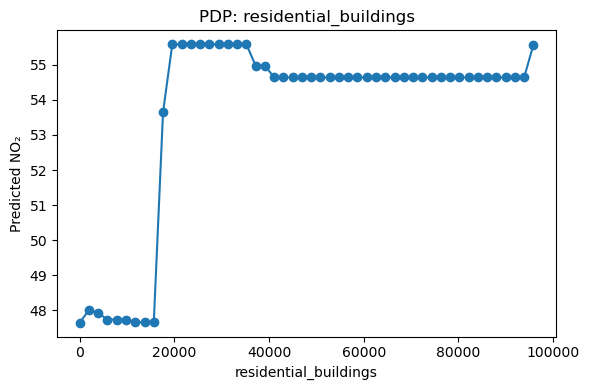

Pre-pandemic: Naive={'MAE': 4.014480015723101, 'RMSE': 8.108878106776919, 'SMAPE': 0.0673036393718248}, XGBoost={'MAE': 6.250249054387715, 'RMSE': 10.196007300026443, 'SMAPE': 0.11507494862036535}


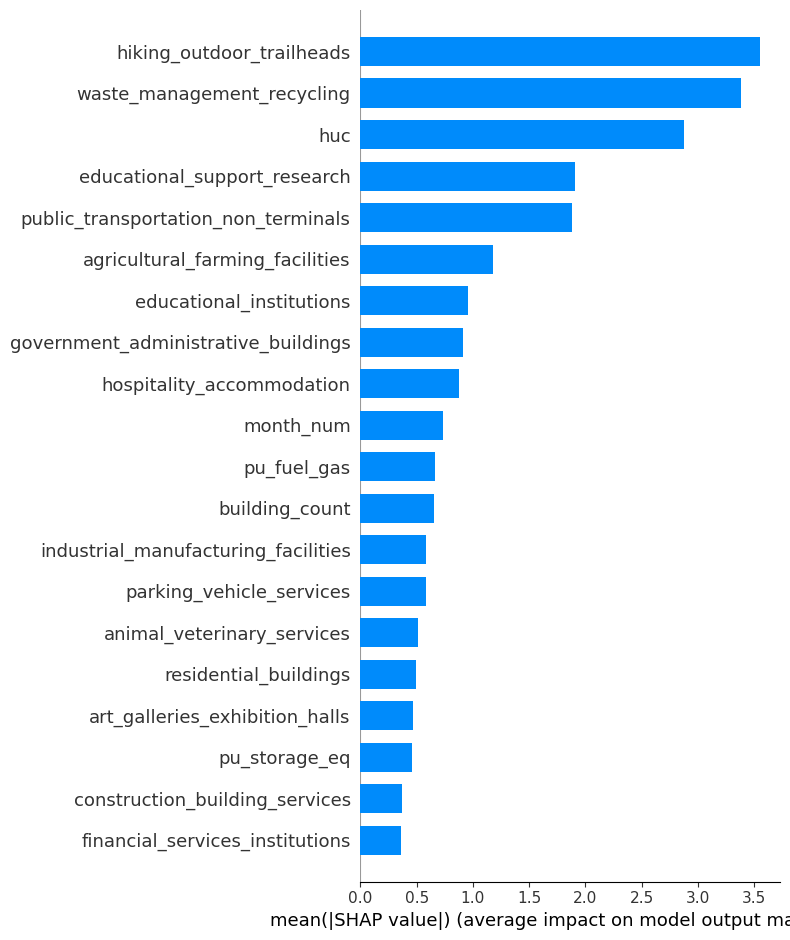

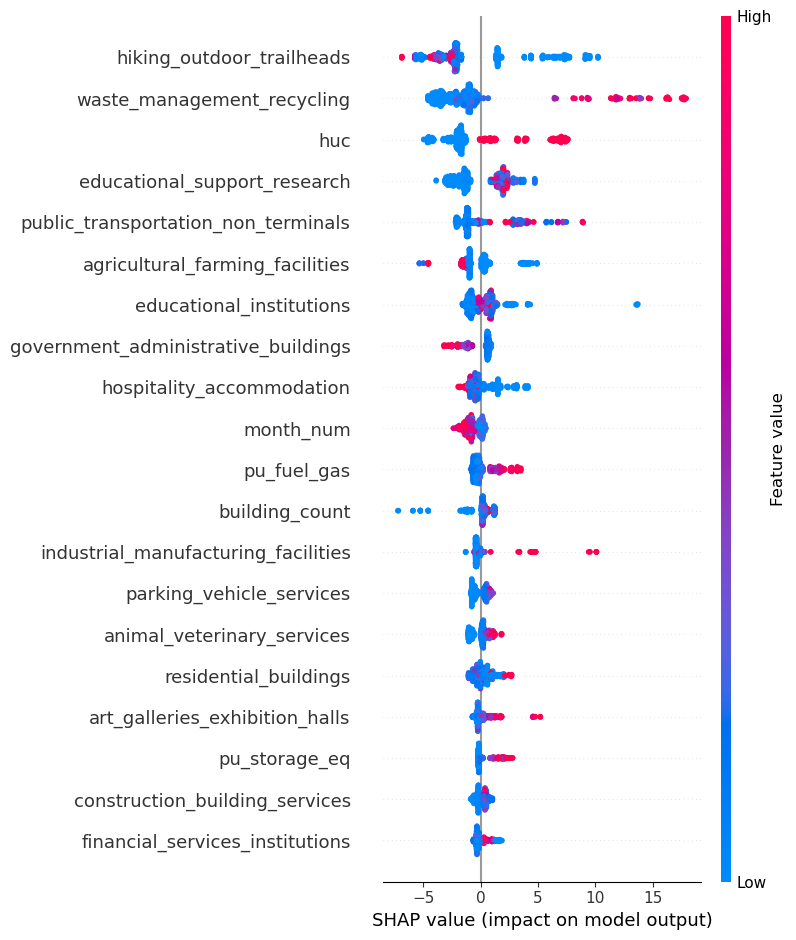

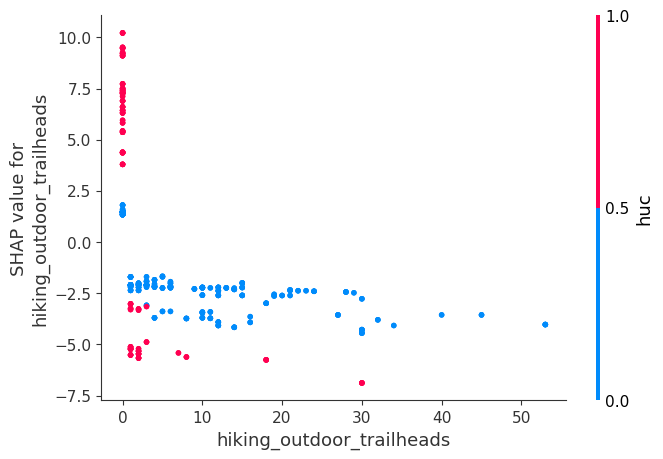

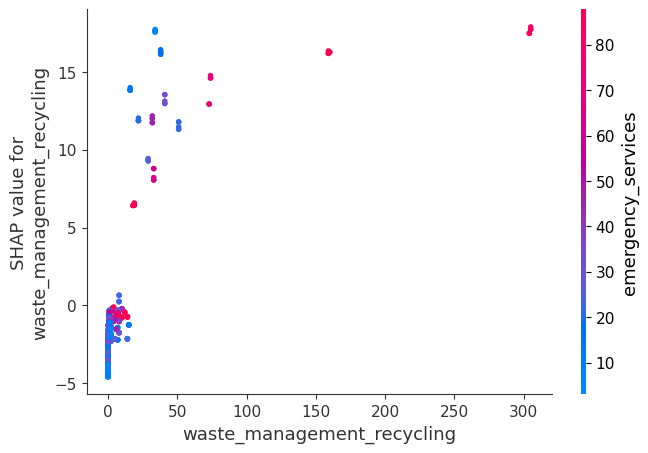

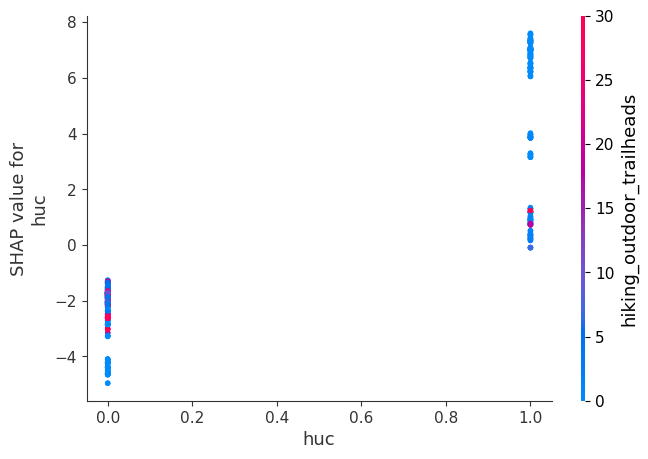

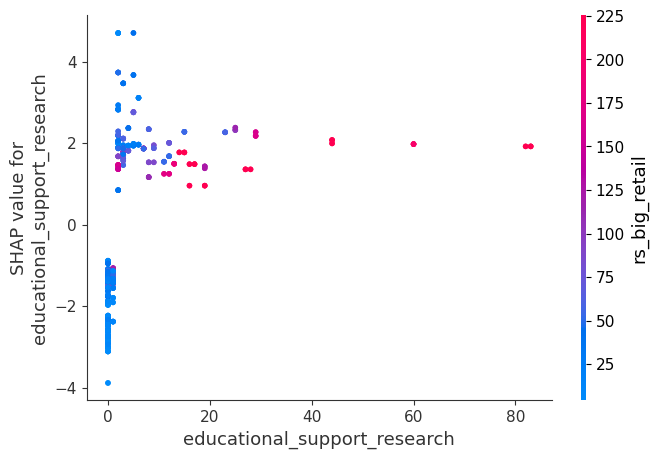

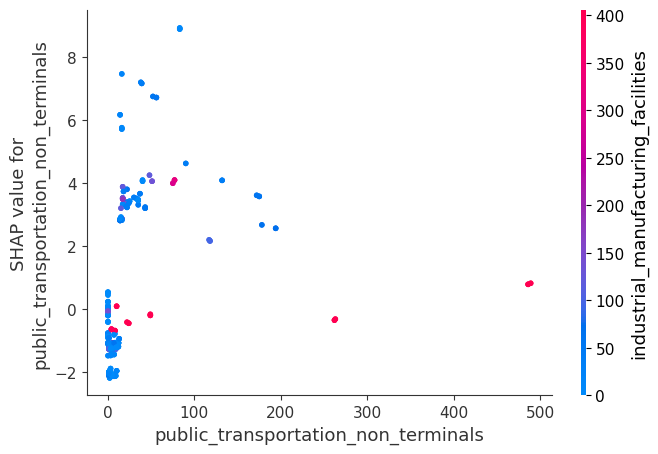

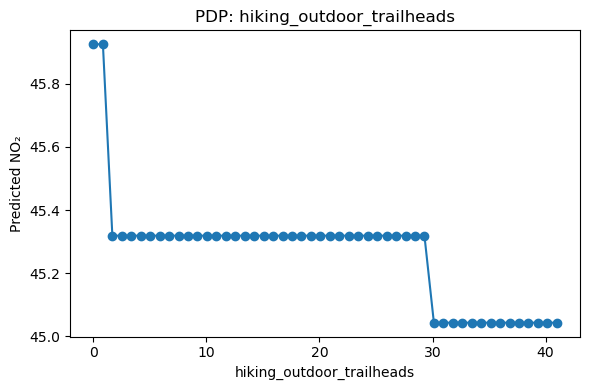

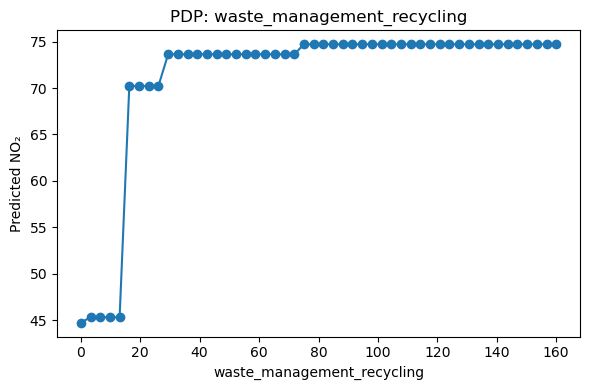

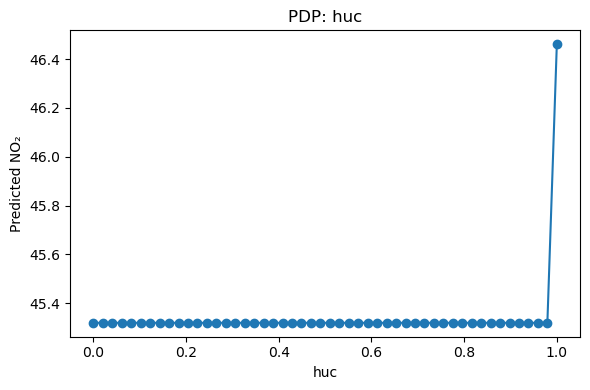

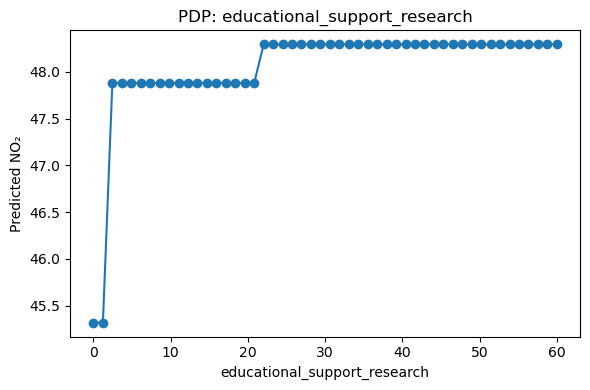

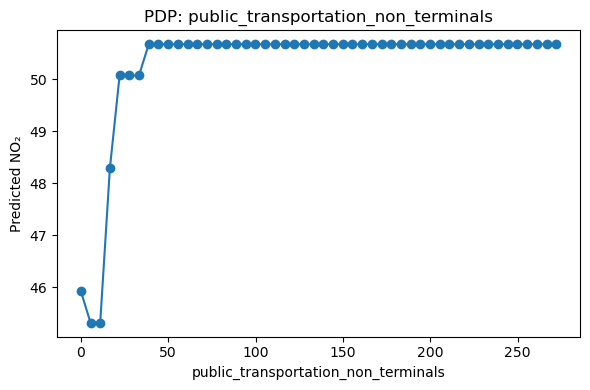

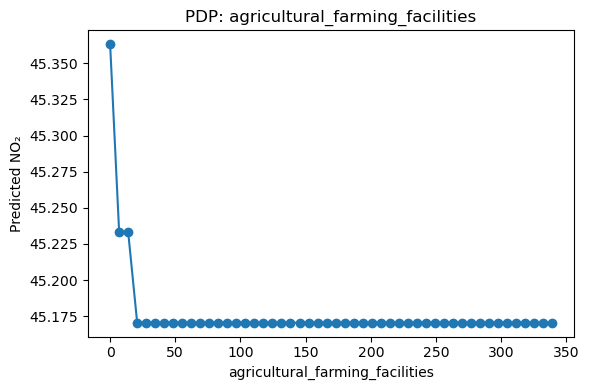

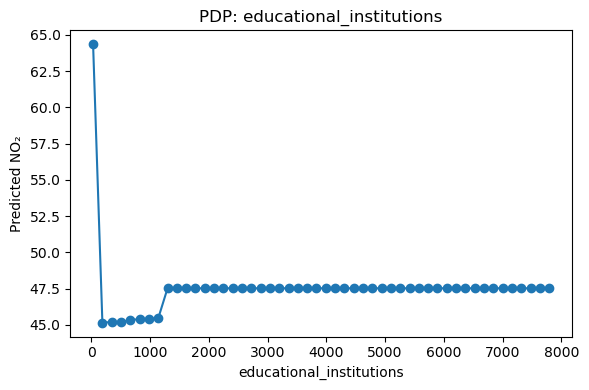

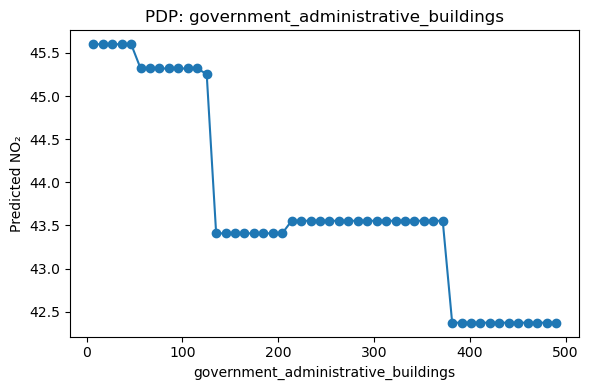

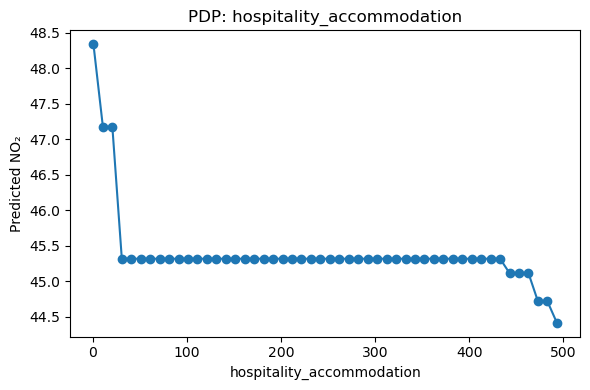

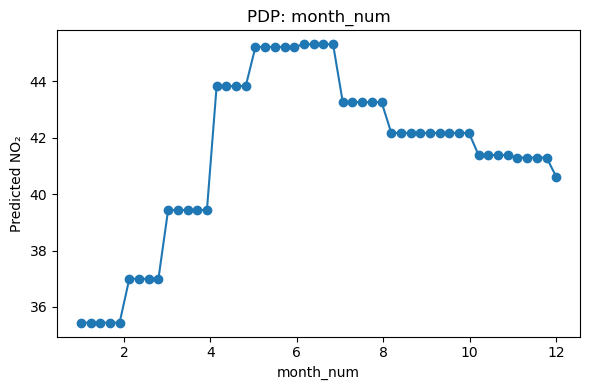

During-pandemic: Naive={'MAE': 2.9805142330437446, 'RMSE': 4.943397329921764, 'SMAPE': 0.04857276019184429}, XGBoost={'MAE': 3.360821952991395, 'RMSE': 4.778042169459791, 'SMAPE': 0.061140322179013926}


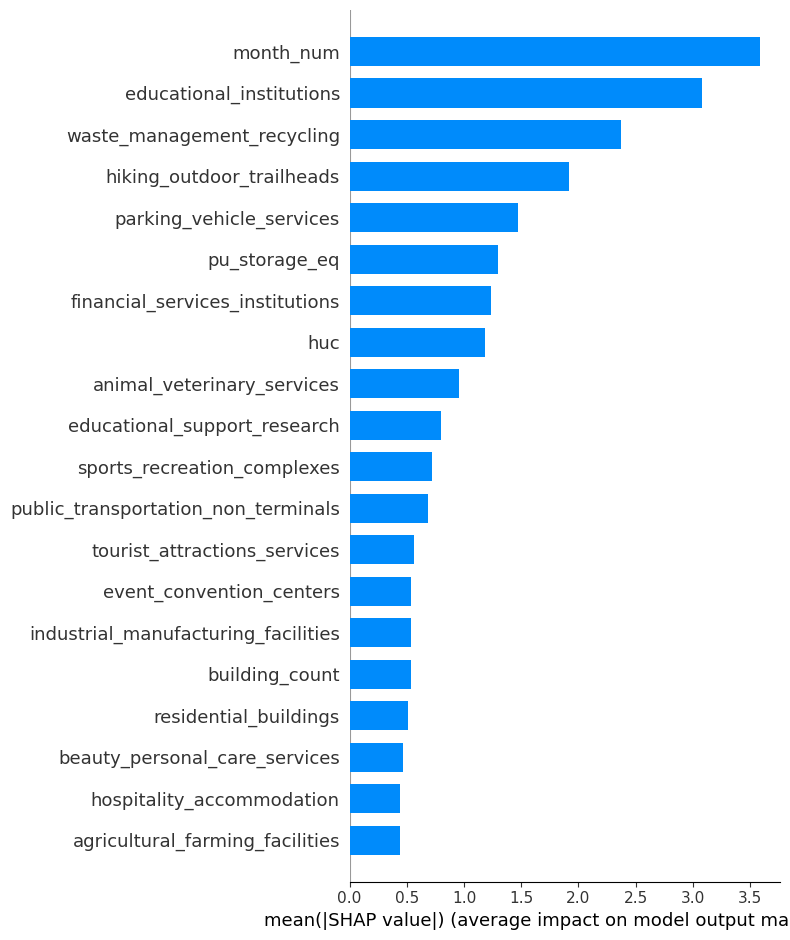

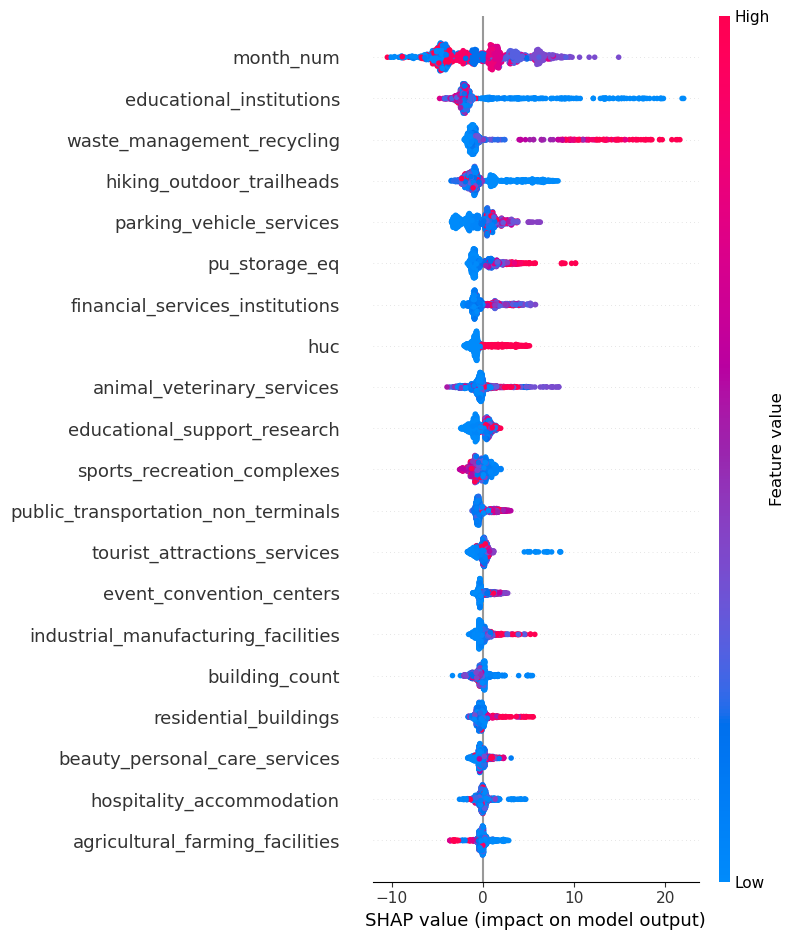

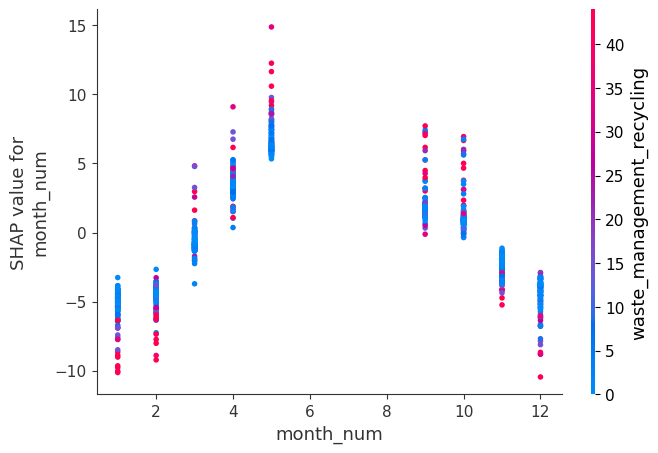

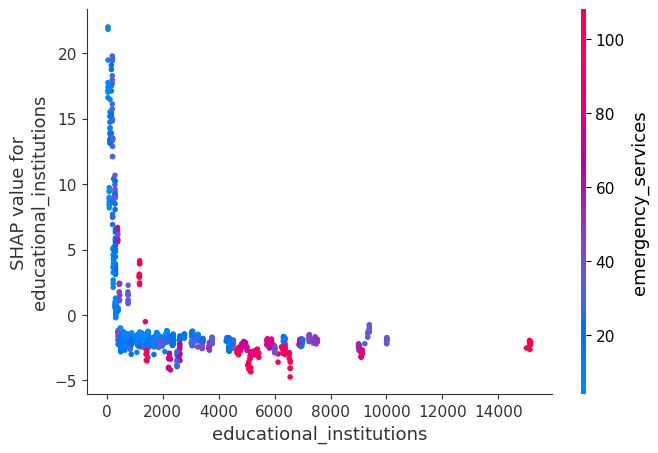

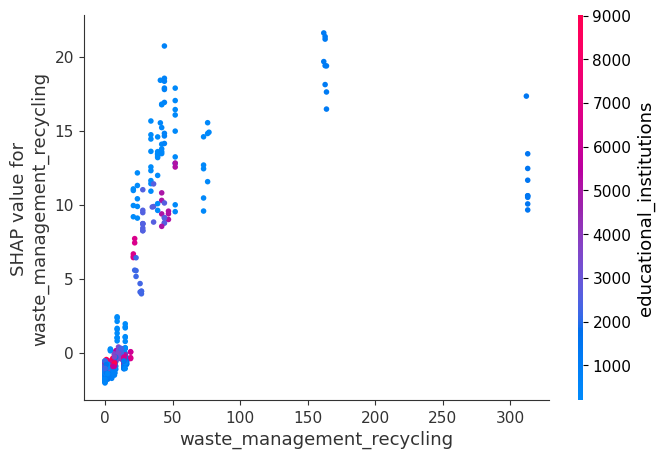

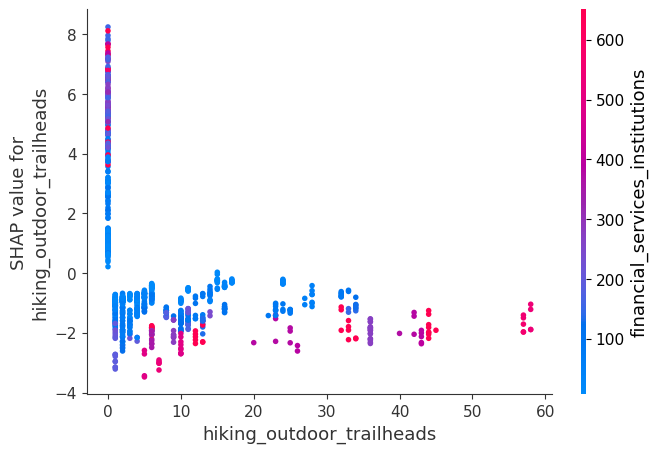

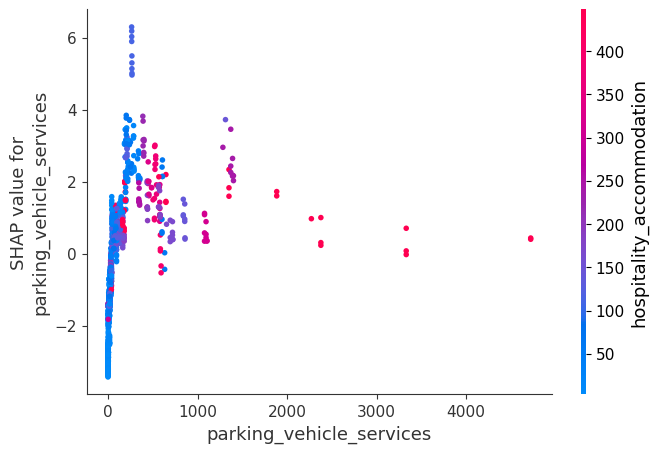

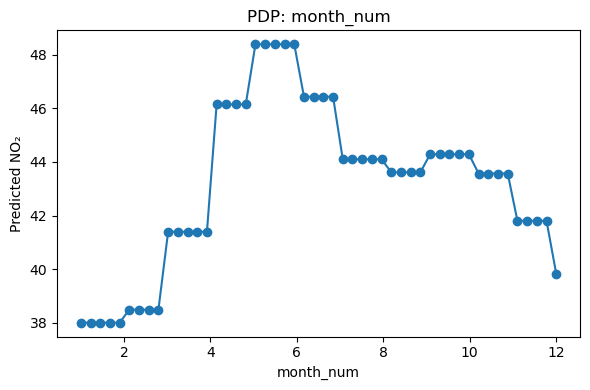

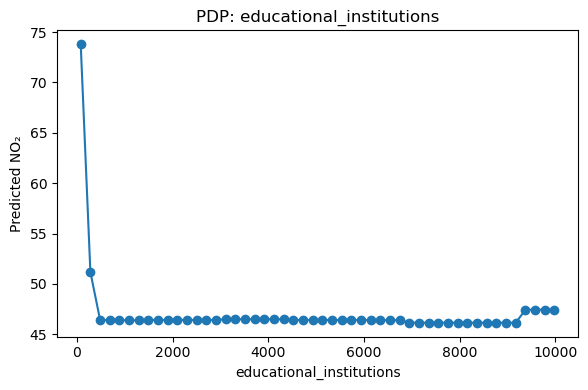

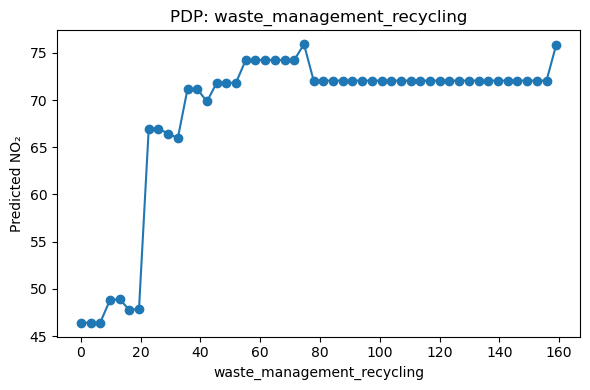

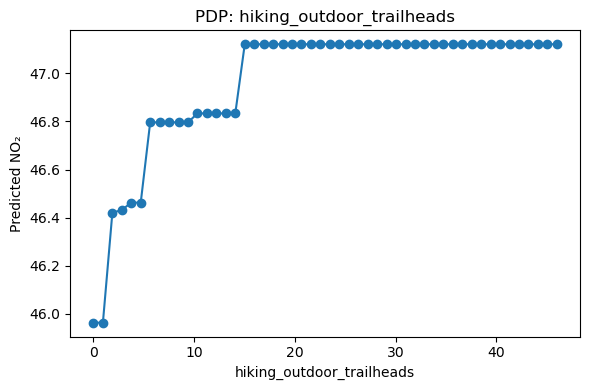

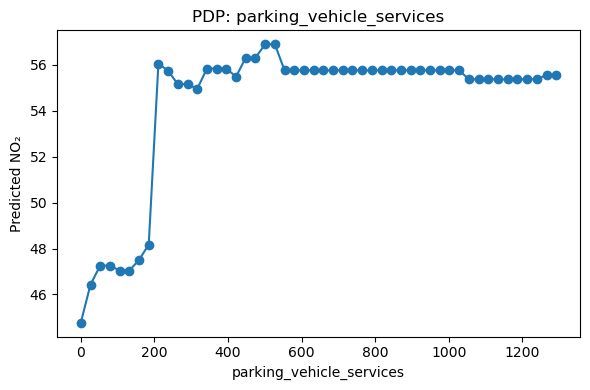

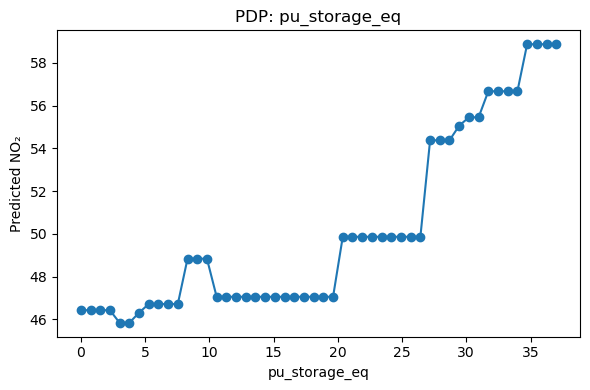

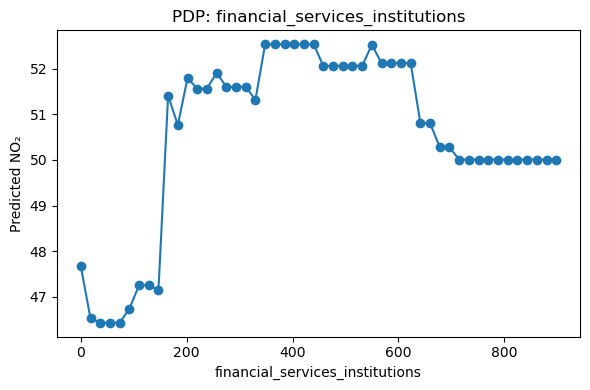

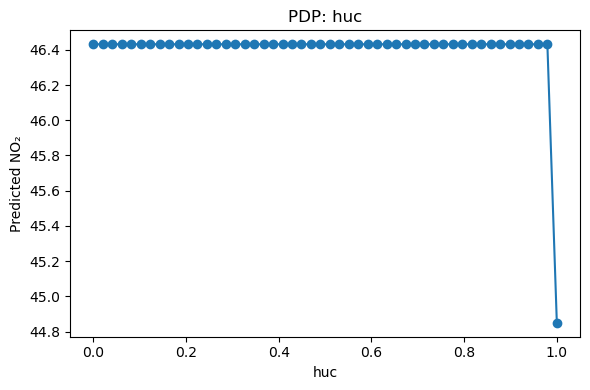

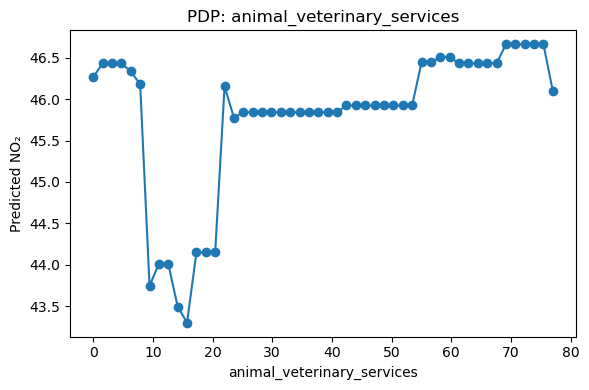

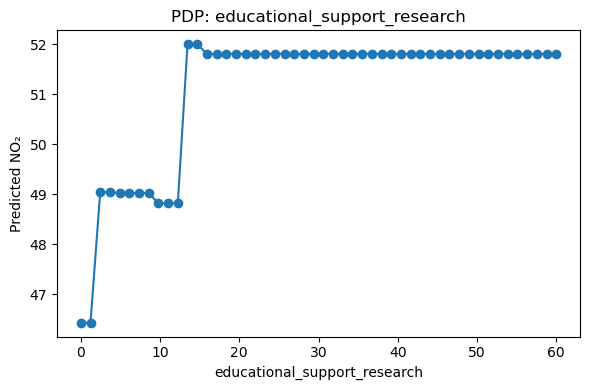

Post-pandemic: Naive={'MAE': 4.3628693560827845, 'RMSE': 7.573211188155469, 'SMAPE': 0.07346189090736557}, XGBoost={'MAE': 4.4000523885646325, 'RMSE': 6.572706636513275, 'SMAPE': 0.08132266970882858}


In [32]:
periods = {
    'Pre-pandemic': df_full[df_full['month'] < '2020-03-01'],
    'During-pandemic': df_full[(df_full['month'] >= '2020-03-01') & (df_full['month'] < '2022-01-01')],
    'Post-pandemic': df_full[df_full['month'] >= '2022-01-01']
}
res = {}
for name, subset in periods.items():
    train_df, val_df = time_based_split(subset)
    naive_metrics = evaluate_naive(val_df)
    xgb_model, xgb_metrics, top10_feats = train_and_evaluate_xgb(train_df, val_df)
    res[name] = {
        'naive': naive_metrics,
        'xgb': xgb_metrics,
        'top10': top10_feats,
        'model': xgb_model,
        'X_val': val_df.drop(columns=EXCLUDE, errors='ignore').select_dtypes(include='number')
    }
    print(f"{name}: Naive={naive_metrics}, XGBoost={xgb_metrics}")

### 5) MODEL COMPARISON TABLE

In [33]:
summary = pd.DataFrame([
    {'Period': period, 'Model': model_type, **metrics}
    for period, vals in res.items()
    for model_type, metrics in [('Naive', vals['naive']), ('XGBoost', vals['xgb'])]
])
summary['SMAPE'] = (summary['SMAPE'] * 100).round(2).astype(str) + '%'
summary[['MAE', 'RMSE']] = summary[['MAE', 'RMSE']].round(2)
print('\nModel Comparison Table:')
print(summary.to_string(index=False))

# ------------------------------------------------------------
# 6) TOP 10 FEATURE CONTRIBUTIONS TABLE
# ------------------------------------------------------------
top10_rows = []
for period, vals in res.items():
    for rank, (feat, imp) in enumerate(vals['top10'], start=1):
        top10_rows.append({
            'Period': period,
            'Rank': rank,
            'Feature': feat,
            'MeanAbsSHAP': round(imp, 4)
        })
features_df = pd.DataFrame(top10_rows)
print('\nTop 10 Feature Contributions per Period:')
print(features_df.to_string(index=False))


Model Comparison Table:
         Period   Model  MAE  RMSE  SMAPE
   Pre-pandemic   Naive 4.01  8.11  6.73%
   Pre-pandemic XGBoost 6.25 10.20 11.51%
During-pandemic   Naive 2.98  4.94  4.86%
During-pandemic XGBoost 3.36  4.78  6.11%
  Post-pandemic   Naive 4.36  7.57  7.35%
  Post-pandemic XGBoost 4.40  6.57  8.13%

Top 10 Feature Contributions per Period:
         Period  Rank                             Feature  MeanAbsSHAP
   Pre-pandemic     1                           month_num       5.7562
   Pre-pandemic     2                                 huc       4.2944
   Pre-pandemic     3           hiking_outdoor_trailheads       1.8245
   Pre-pandemic     4          gambling_casino_facilities       1.7209
   Pre-pandemic     5     financial_services_institutions       1.3558
   Pre-pandemic     6 public_transportation_non_terminals       1.3362
   Pre-pandemic     7      entertainment_nightlife_venues       1.2429
   Pre-pandemic     8            educational_institutions       1.0981


### 6 PDP FOR METROPOLITAN CITIES POST PANDEMIC

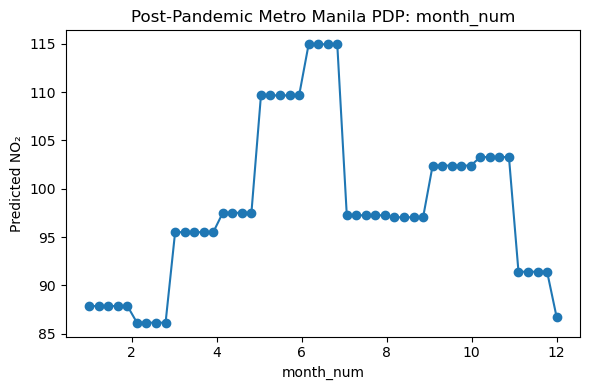

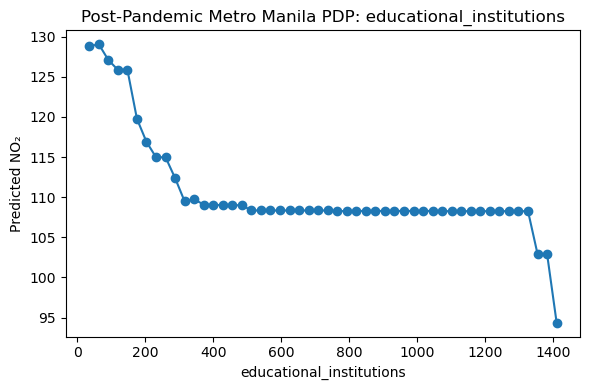

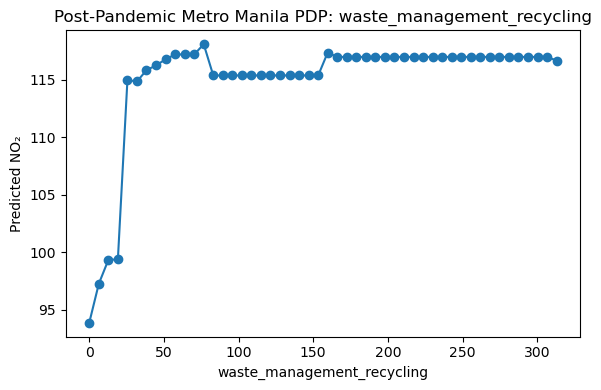

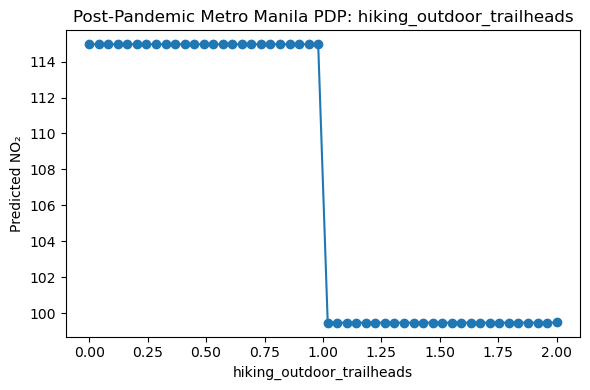

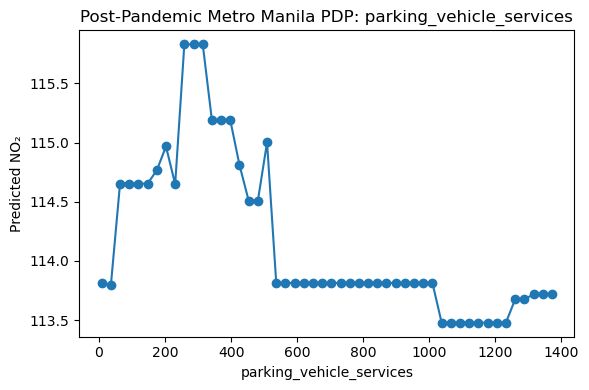

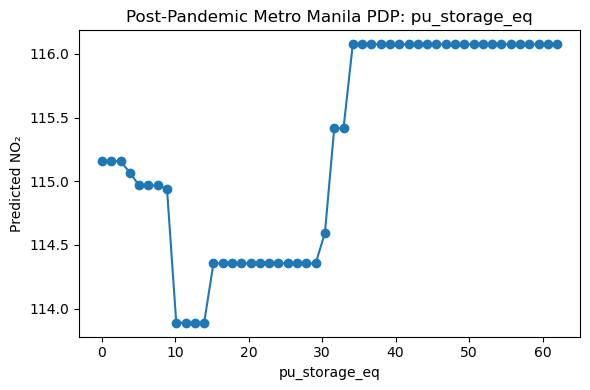

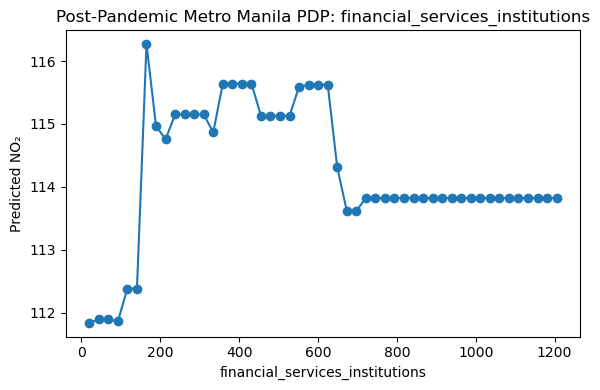

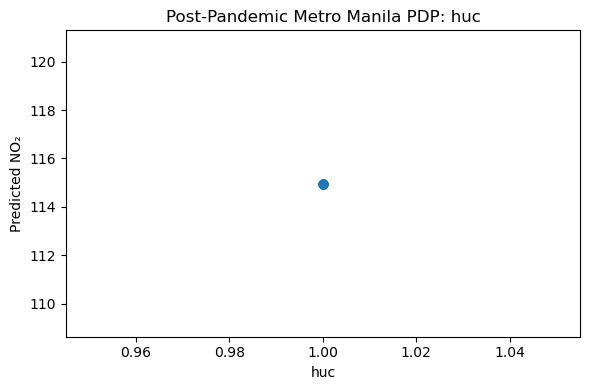

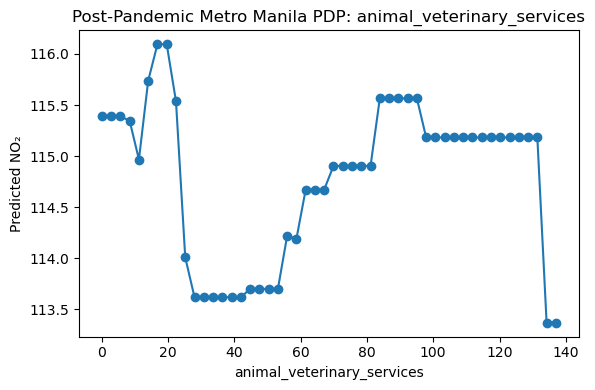

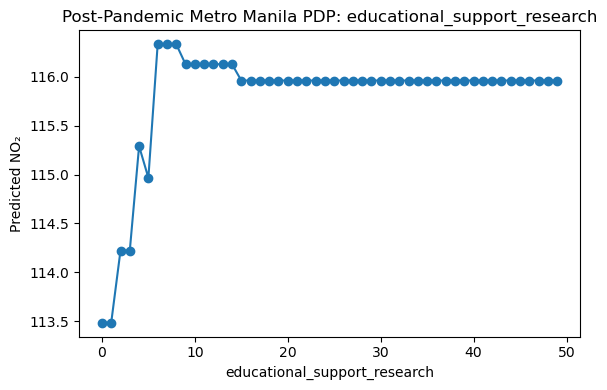

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Metro Manila city list (adjust if needed)
metro_cities = [
    'city of manila', 'quezon city', 'city of caloocan', 'city of las piñas',
    'city of makati', 'city of malabon', 'city of mandaluyong', 'city of marikina',
    'city of muntinlupa', 'city of navotas', 'city of parañaque', 'pasay city',
    'city of pasig', 'pateros', 'city of san juan', 'city of taguig'
]

# 1) Pull out your post-pandemic model + features
post_model    = res['Post-pandemic']['model']
post_top10    = res['Post-pandemic']['top10']   # list of (feat, importance)
post_period   = periods['Post-pandemic']        # DataFrame of post-pandemic rows

# 2) Build the Metro Manila numeric matrix
df_metro = post_period[post_period['region'].isin(metro_cities)]
X_metro  = df_metro.drop(columns=EXCLUDE + ['month'], errors='ignore') \
                   .select_dtypes(include='number')

# 3) Compute the Metro median profile
metro_median = X_metro.median()

# 4) Loop over the top-10 features from your post-pandemic run
for feat, _ in post_top10:
    # 4a) Grid between 1st–99th percentile **within** Metro Manila
    grid = np.linspace(
        X_metro[feat].quantile(0.01),
        X_metro[feat].quantile(0.99),
        50
    )
    # 4b) Make a DataFrame at the Metro median, varying only this feature
    df_grid = pd.DataFrame(
        np.repeat(metro_median.values[None, :], len(grid), axis=0),
        columns=X_metro.columns
    )
    df_grid[feat] = grid

    # 4c) Predict and plot
    y_pred = post_model.predict(df_grid)
    plt.figure(figsize=(6, 4))
    plt.plot(grid, y_pred, marker='o')
    plt.title(f'Post-Pandemic Metro Manila PDP: {feat}')
    plt.xlabel(feat)
    plt.ylabel('Predicted NO₂')
    plt.tight_layout()
    plt.show()


## PDP REGION POST-PANDEMIC

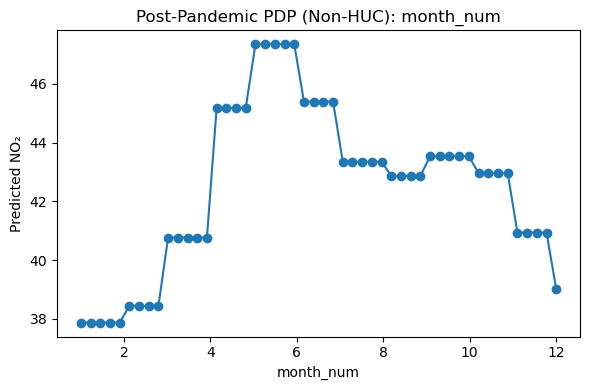

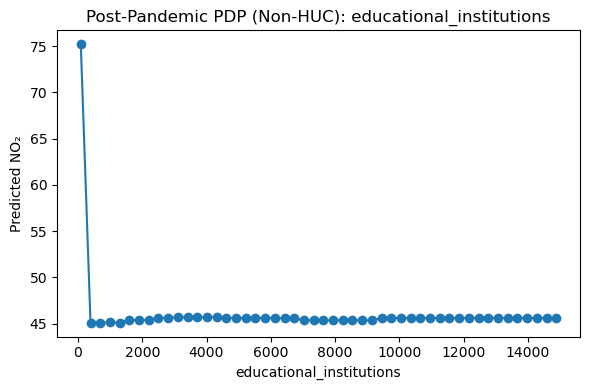

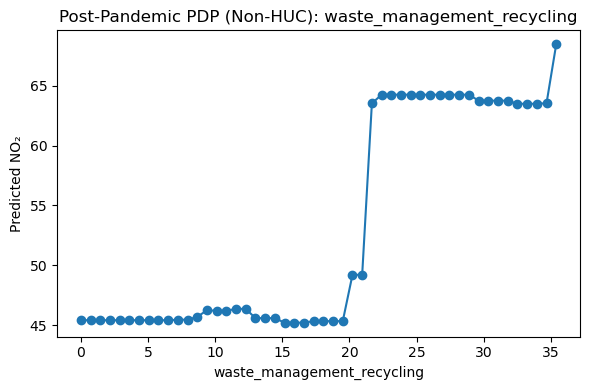

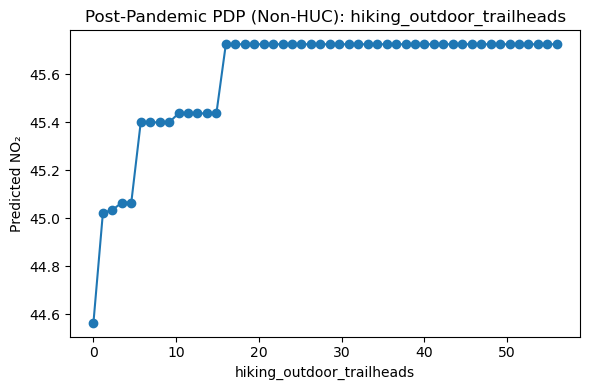

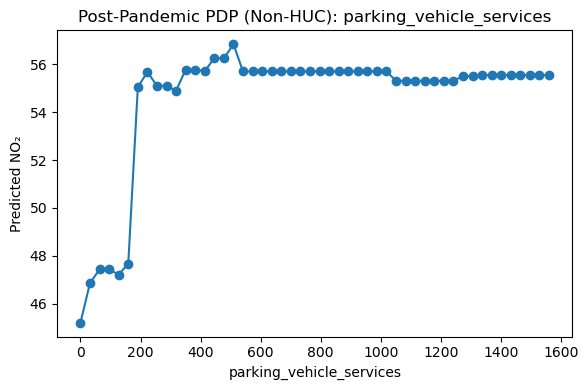

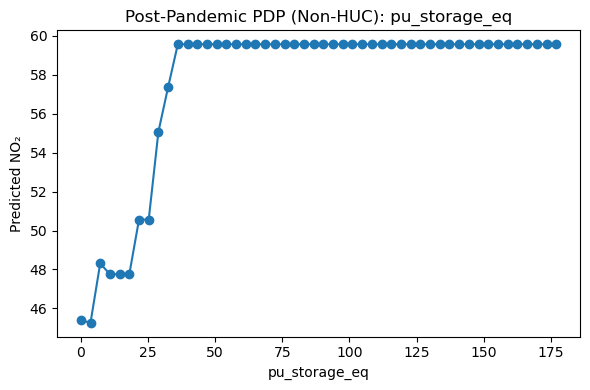

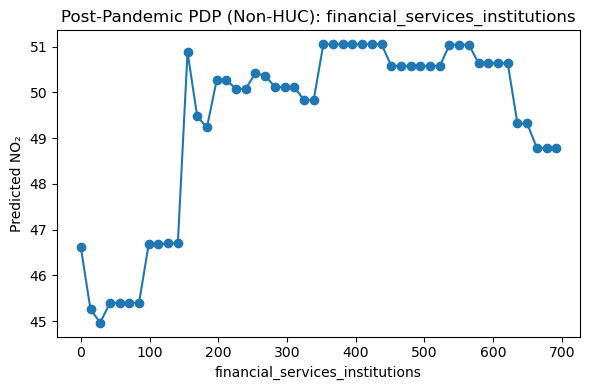

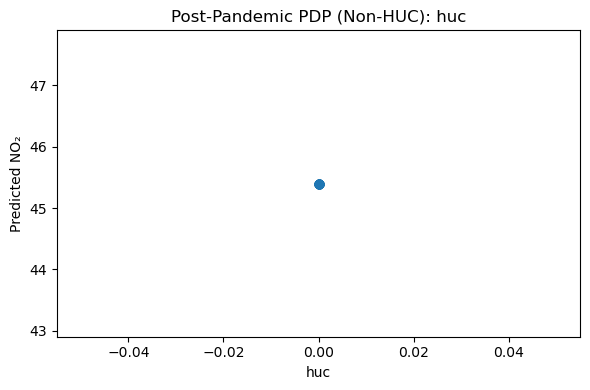

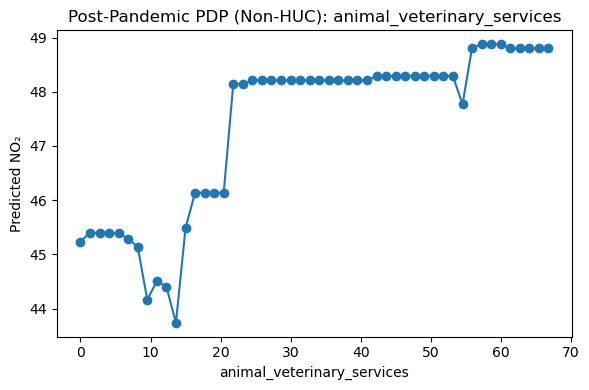

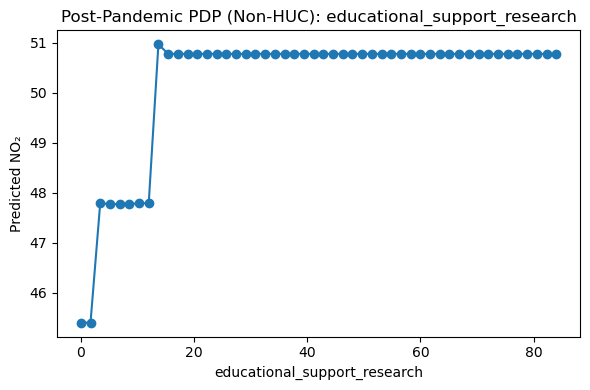

In [35]:
# 1) Pull out your post-pandemic model + features
post_model    = res['Post-pandemic']['model']   # 
post_top10    = res['Post-pandemic']['top10']   # list of (feat, importance)
post_period   = periods['Post-pandemic']        # DataFrame of post-pandemic rows

# 2) Filter to NON-HUC regions only
df_nonhuc = post_period[~post_period['region'].str.lower().isin(huc_list)]
X_nonhuc  = df_nonhuc.drop(columns=EXCLUDE + ['month'], errors='ignore') \
                     .select_dtypes(include='number')

# 3) Compute the median profile for non-HUC regions
nonhuc_median = X_nonhuc.median()

# 4) Loop over the top-10 features
for feat, _ in post_top10:
    # 4a) Grid between 1st–99th percentile in non-HUC data
    grid = np.linspace(
        X_nonhuc[feat].quantile(0.01),
        X_nonhuc[feat].quantile(0.99),
        50
    )

    # 4b) Create grid DataFrame at median, varying only one feature
    df_grid = pd.DataFrame(
        np.repeat(nonhuc_median.values[None, :], len(grid), axis=0),
        columns=X_nonhuc.columns
    )
    df_grid[feat] = grid

    # 4c) Predict and plot
    y_pred = post_model.predict(df_grid)
    plt.figure(figsize=(6, 4))
    plt.plot(grid, y_pred, marker='o')
    plt.title(f'Post-Pandemic PDP (Non-HUC): {feat}')
    plt.xlabel(feat)
    plt.ylabel('Predicted NO₂')
    plt.tight_layout()
    plt.show()